# Mini-projet n°3 - ViT vs CNN

L'objectif de ce mini-projet est de comparer les performances de deux architectures différentes pour de la classification d'image : les Vision Transformers (ViT) et les Convolutional Neural Networks (CNN).

Pour les comparer, nous allons mesurer la justesse de leur classification, leur coût en temps d'entrainement et leur interpétabilité. 

# Choix des deux datasets

Nous avons sélectionné deux datasets pour comparer les performances de classification entre un Vision Transformer (ViT) et un réseau de neurones convolutif (CNN). 

Le premier est un dataset contenant des photos de personnes exprimant une émotion, et sont labellisés dans cinq catégories différentes: 'angry' (la colère), 'sad' (la tristesse), 'surprise' (la surprise), 'happy' (la joie) et 'fear' (la peur). Nous avons choisi ce premier data set car il était très complet, et nous avons remarqué que les ViT étaient efficaces sur de grands datasets. De plus, étant donnée la différence d'expression des sentiments selon les personnes, nous avons considéré qu'il serait intéressant d'étudier la classification faite par l'ordinateur de deux manières différentes. 

Le deuxième dataset que nous avons sélectionné regroupe des peintures, labellisés en fonction de l'artiste. Il se trouve à l'adresse suivante : https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time?select=images. 
Nous trouvons cette base de données particulièrement interessante par sa large diversité d'artistes considérés. Les images sont également de bonne qualité et nous voulons tester la capacité des différents modèle à reconnaitre un style artistique.

Nous avons porté attention à ce que les deux bases de données soient organisées de façon analogue pour uniformiser les fonctions utilisées pour les pré-traitements d'images.

## Analyse exploratoire

Commençons par importer les librairies utiles.

In [1]:
# Maths et Utils
import numpy as np
import os
import pandas as pd
import time

In [2]:
# Affichage 
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from timm import create_model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Analyse du dataset "Emotions"

In [5]:
def summarize_dataset(root_dir):
    #Récupération des noms de dossier correspondant aux noms de classes
    classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]) 
    stats = {}

    for cls in classes:
        cls_path = os.path.join(root_dir, cls)
        imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(("jpg","jpeg","png"))]
        stats[cls] = len(imgs)
    
    return pd.DataFrame({"Classe": list(stats.keys()), "Nombre d'images": list(stats.values())})

df_emotions = summarize_dataset("emotions/Data")

In [6]:
df_emotions

,Classe,Nombre d'images
0,Angry,10148
1,Fear,9732
2,Happy,18439
3,Sad,12553
4,Suprise,8227


La base de données "émotions" est composées de 5 classes différentes, équivalentes aux 5 émotions décrites plus tôt. Ces différentes émotions sont représentées de manière équitable, excepté la joie qui est possède bien plus d'images. 

In [7]:
def count_images(root):
    # compter les images de chaque classes
    classes = sorted(os.listdir(root))
    return {cls: len([f for f in os.listdir(os.path.join(root, cls)) 
                      if f.lower().endswith(("jpg","png","jpeg"))]) 
            for cls in classes}

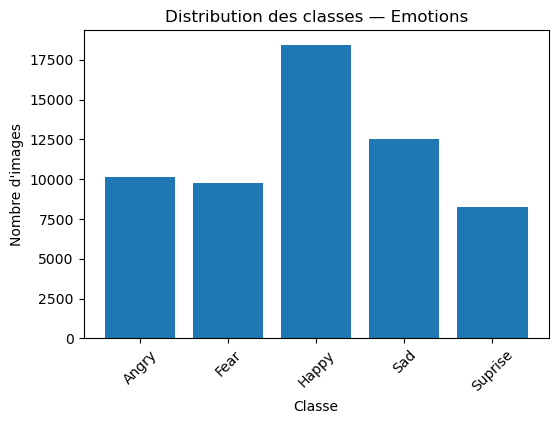

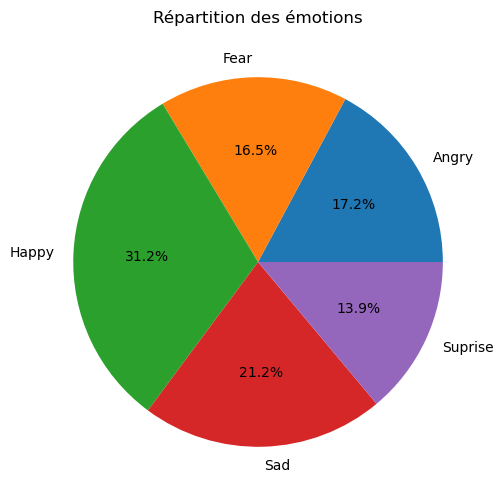

In [8]:
# Comptage des images
emotion_counts = count_images("emotions/Data")

# Barplot
plt.figure(figsize=(6,4))
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.title("Distribution des classes — Emotions")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.show()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(emotion_counts.values(), labels=emotion_counts.keys(), autopct='%1.1f%%')
plt.title("Répartition des émotions")
plt.show()

On voit bien que l'émotion "Happy" représente 31.2% des photos, soit jusqu'à deux fois plus que la peur, la surprise ou la colère. Cela pourrait avoir un impact sur les performances après entrainement, puisque des classes sont plus représentées que d'autres. 

In [9]:
def show_samples(root_dir, n=3):
    classes = sorted(os.listdir(root_dir))
    plt.figure(figsize=(12, len(classes)*2.5))

    index = 1
    for cls in classes:
        cls_path = os.path.join(root_dir, cls)
        imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(("jpg","jpeg","png"))][:n]
        
        for img_name in imgs:
            img = Image.open(os.path.join(cls_path, img_name))
            plt.subplot(len(classes), n, index)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
            index += 1

Nous pouvons maintenant afficher un échantillon d'images de ce dataset. 

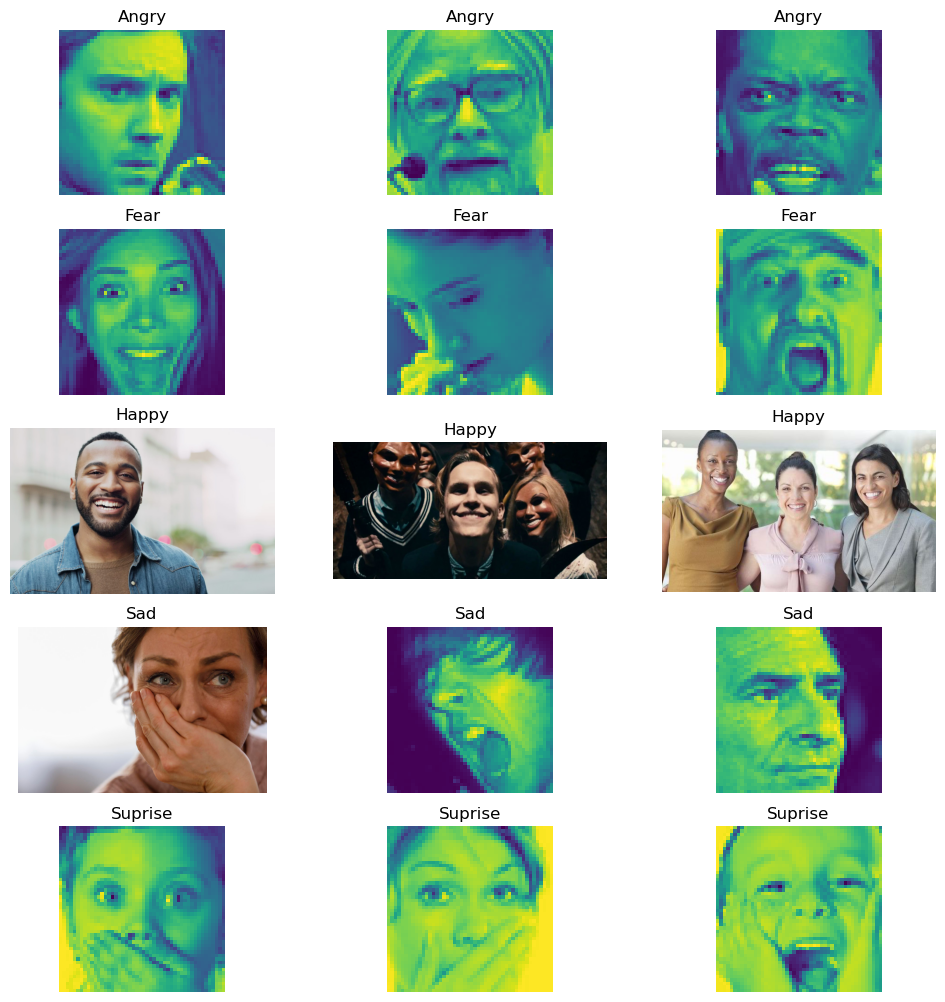

In [10]:
show_samples("emotions/Data")

On observe que dans le dataset 'Emotions', certaines des images sont en noir et blanc (l'affichage les rend vertes) tandis que d'autres sont en couleurs. Encore une fois, il est important de souligner que cela risque d'altérer les résultats lors de la classification plus tard.

Observons à présent les différentes propriétés des images présentent dans les deux bases de données afin de s'assurer une comparaison juste des performances des deux modèles. Etablissons quelque mesures sur nos images pour mieux comprendre nos données. La fonction suivante a pour objectifs de mesurer les tailles et les canneaux de nos images pour avoir des informations sur les différences entre les images, et les besoins de prétraitement spécifique à chaque base de données.  

In [11]:
IMG_EXTS = ('.png', '.jpg', '.jpeg')

def dataset_image_stats(folder, min_width=224, min_height=224):
    # on veut :
    # nombre d'images valides, nombre d'image corrompues
    # nombre de petites images (< à un certain seuil)
    # les tailles minimales, médianes et maximales
    # la distribution des modes (RGB/L/RGBA)
    # aspect ratio min/max (w/h)
    widths, heights, ratios = [], [], []
    modes = {}
    total_files = 0
    corrupted = 0
    small = 0

    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(IMG_EXTS):
                total_files += 1
                path = os.path.join(root, f)
                try:
                    with Image.open(path) as img:
                        img.load()
                        w, h = img.size
                        widths.append(w)
                        heights.append(h)
                        ratios.append(w / h if h != 0 else 0)

                        modes[img.mode] = modes.get(img.mode, 0) + 1

                        if w < min_width or h < min_height:
                            small += 1

                except Exception:
                    corrupted += 1

    if total_files == 0:
        print(f"[{folder}] Aucune image trouvée.")
        return None

    valid = total_files - corrupted
    if valid == 0:
        print(f"[{folder}] Aucune image valide (tout est corrompu).")
        return None

    widths_sorted = sorted(widths)
    heights_sorted = sorted(heights)

    def median(lst):
        n = len(lst)
        return lst[n//2] if n % 2 == 1 else (lst[n//2 - 1] + lst[n//2]) / 2

    w_min, w_med, w_max = min(widths_sorted), median(widths_sorted), max(widths_sorted)
    h_min, h_med, h_max = min(heights_sorted), median(heights_sorted), max(heights_sorted)
    r_min, r_max = min(ratios), max(ratios)

    return {
        "total_files": total_files,
        "valid": valid,
        "corrupted": corrupted,
        "small": small,
        "w_min": w_min, "w_med": w_med, "w_max": w_max,
        "h_min": h_min, "h_med": h_med, "h_max": h_max,
        "r_min": r_min, "r_max": r_max,
        "modes": modes
    }

In [12]:
dataset_image_stats("emotions/Data")

KeyboardInterrupt: 

Notre première base possède un grand nombre d'image et aucune ne semble corrompue. Cependant, nous constatons que la grande majorité des images sont trop petites pour un modèle du type ImageNet car 97.83% des images sont en dessous, soit en hauteur soit en largeur, des 224x224 conseillés. En moyenne les images font du 48x48 pixels. Les modes nous indique également que la majeur partie des images sont en noir et blanc. On peut supposer que ces images restent exploitables pour un modèle de type CNN. 

### Analyse du dataset "Art"

In [14]:
df_art = summarize_dataset("art/images")
df_art 

,Classe,Nombre d'images
0,Albrecht_DuÔòá├¬rer,328
1,Albrecht_Du╠êrer,328
2,Alfred_Sisley,259
3,Amedeo_Modigliani,193
4,Andrei_Rublev,99
5,Andy_Warhol,181
6,Camille_Pissarro,91
7,Caravaggio,55
8,Claude_Monet,73
9,Diego_Rivera,70


La base de donnée Art considère 50 artistes, ce qui donne bien plus de classes. Le nombre d'oeuvres par artiste semble beaucoup varier. 

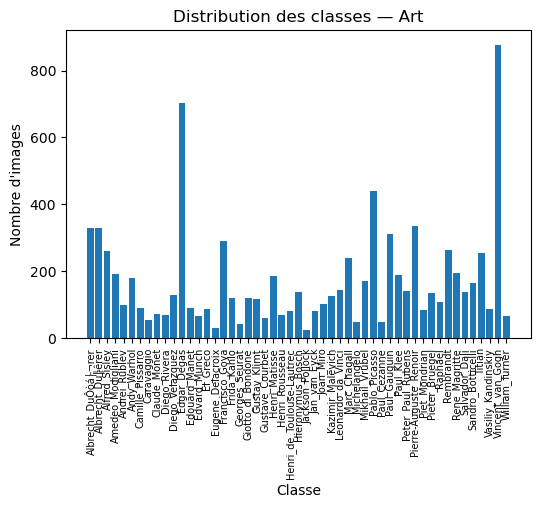

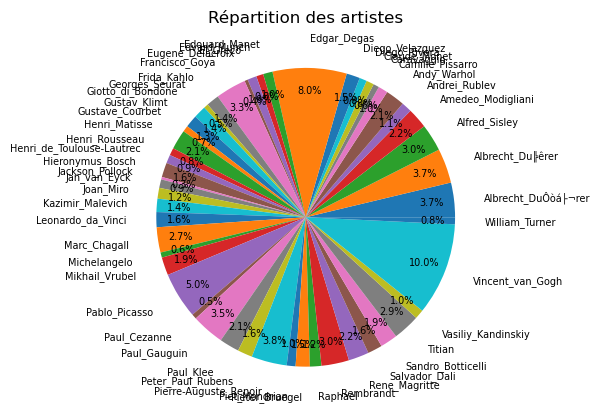

In [15]:
art_counts = count_images("art/images")

# Barplot
plt.figure(figsize=(6,4))
plt.bar(art_counts.keys(), art_counts.values())
plt.title("Distribution des classes — Art")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=90, fontsize=7)
plt.show()

# Pie Chart
plt.figure(figsize=(6,6))

wedges, texts, autotexts = plt.pie(
    art_counts.values(),
    labels=art_counts.keys(),
    autopct='%1.1f%%',
    pctdistance=0.85,  
    labeldistance=1.2, 
    textprops={'fontsize': 7}
)

plt.title("Répartition des artistes")
plt.tight_layout()
plt.show()


On constate que pour cette base de données, les effectifs sont assez hétérogènes. En effet, Van Gogh et Degas sont bien plus représentés que les autres. 

Nous pouvons visualiser un échantillon d'images.

In [16]:
show_samples("art")

<Figure size 1200x250 with 0 Axes>

In [17]:
dataset_image_stats("art")

{'total_files': 8774,
 'valid': 8774,
 'corrupted': 0,
 'small': 8,
 'w_min': 204,
 'w_med': 815.0,
 'w_max': 4096,
 'h_min': 226,
 'h_med': 959.0,
 'h_max': 3826,
 'r_min': 0.2021484375,
 'r_max': 5.601750547045952,
 'modes': {'RGB': 8702, 'L': 72}}

Cette deuxième base de données possède beaucoup moins d'image que la première, mais il y a moins d'un pourcent de ces images qui sont en dessous des 224x224 pixels recommandés pour des modèles ViT. Les images sont cependant en moyenne bien au dessus de cette taille ce qui peut impliquer une perte d'information à travers d'éventuelles resize. 
Cette base de données possède une majorité d'images RGB. 

# Préparation données

In [23]:
class CustomImageDataset(Dataset):
    "permet de fournir des couples (image, label) pour faciliter la mise en place des structures de données pour l'utilisation des modèles"
    
    def __init__(self, df, path_images, transform=None):
        self.df = df.reset_index(drop=True)
        self.path_images = path_images
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx] 
        img_path = os.path.join(self.path_images, row["image"])

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image manquante : {img_path}")

        image = Image.open(img_path).convert("RGB") #convertion en RGB pour la base de donnée émotion

        if self.transform:
            image = self.transform(image)

        label = row["class"]
        return image, label

## Base de données "Emotions"

In [24]:
# Définition des Transformations
img_width, img_height = 224, 224 # En préparation pour le passage dans un Vit
batch_size = 16


# Train sans augmentation
train_transforms = transforms.Compose([
    transforms.Resize((img_width, img_height)), #mise à l'echelle avec interpolation pas de crop
    transforms.ToTensor(), # ToTensor() convertit [0,255] → [0,1] et change la forme : (H,W,C) → (C,H,W)
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]) #pour une utilisation avec un modèle pré-entrainé
])

# Train avec augmentation
train_transforms_aug = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.RandomHorizontalFlip(), #Une émotion reste la même si on inverse gauche-droite : diversification naturelle
    transforms.RandomRotation(40), #Amélioration de la robustesse en ajoutant une rotation (tenter 15 si trop fort)
    #On veut différencier reconnaissance d'une émotion des paramettres de couleurs de l'image
    #Attention à ne pas en mettre trop risque de perte d'informations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]) #centre et réduit les valeurs de pixel canal par canal/ coeff basé sur ImageNet
])

# Validation / Test (pas d'augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Les transformations appliquées visent à homogénéiser cette base de donnée, qui est caractérisée par une forte variabilité de tailles, de formats et de conditions d’éclairage. Le redimensionnement en 224×224 permet une compatibilité avec des architectures pré-entraînées sur ImageNet. Des augmentations de données (flip horizontal, rotations, jitter de couleur) sont appliquées uniquement sur le jeu d’entraînement afin d’améliorer la généralisation du modèle, tandis que les jeux de validation et de test conservent des transformations déterministes pour ne pas générer de biais. 

In [25]:
#Chargement du dataset
dataset_path = "emotions/Data"
full_dataset_emotions = datasets.ImageFolder(root=dataset_path)
idx_to_emotion = {v:k for k,v in full_dataset_emotions.class_to_idx.items()}

#Création d'un DataFrame à partir de ImageFolder
image_paths = [
    os.path.relpath(s[0], dataset_path) #transformation en chemin relatif
    for s in full_dataset_emotions.samples
]

labels = [s[1] for s in full_dataset_emotions.samples]

full_df_emotions = pd.DataFrame({'image': image_paths, 'class': labels})

#Calcul des tailles des différents bases
N_total = len(full_df_emotions)
#Entrainement : 80%
N_train = int(0.8 * N_total)
#Validation, Test : 10%, 10%
N_val_test = N_total - N_train
N_val = N_val_test // 2
N_test = N_val_test - N_val

print("Taille train :", N_train, f"( {N_train/N_total*100:.4} % )")
print("Taille validation :", N_val, f"( {N_val/N_total*100:.4} % )")
print("Taille test :", N_test, f"( {N_test/N_total*100:.4} % )")

# Split des différents sets 
train_df_e, val_test_df_e = train_test_split(
    full_df_emotions,
    train_size=N_train,
    stratify=full_df_emotions['class'], #garantit que la proportion de chaque classe est conservée dans train et val_test
    random_state=42
)

val_df_e, test_df_e = train_test_split(
    val_test_df_e,
    train_size=N_val,
    stratify=val_test_df_e['class'],
    random_state=42
)

#Datasets 
#Même base de donnée à l'origine : seule la transformation change
train_dataset_e = CustomImageDataset(train_df_e, dataset_path, transform=train_transforms)
train_dataset_aug_e = CustomImageDataset(train_df_e, dataset_path, transform=train_transforms_aug)

val_dataset_e = CustomImageDataset(val_df_e, dataset_path, transform=val_test_transforms)
test_dataset_e = CustomImageDataset(test_df_e, dataset_path, transform=val_test_transforms)

#DataLoaders
train_loader_e = DataLoader(train_dataset_e, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader_aug_e = DataLoader(train_dataset_aug_e, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_e = DataLoader(val_dataset_e, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_e = DataLoader(test_dataset_e, batch_size=batch_size, shuffle=False, num_workers=2)



Taille train : 47279 ( 80.0 % )
Taille validation : 5910 ( 10.0 % )
Taille test : 5910 ( 10.0 % )


Les images sont chargées via ImageFolder puis regroupées en DataFrame pour pouvoir constituer les jeux de données d'entraînement de validation et de test. Deux jeux d'entrainement sont considérés, un avec augmentation des données et l'autre sans.  
train_dataset_aug contient les mêmes images que train_dataset mais transformées.

In [26]:
full_dataset_emotions = datasets.ImageFolder(
    root=dataset_path,
    transform=train_transforms
)

print(full_dataset_emotions)          
print(full_dataset_emotions.class_to_idx) 
print(len(full_dataset_emotions))     
img, label = full_dataset_emotions[0]
print(img.shape)             
print(label)

Dataset ImageFolder
    Number of datapoints: 59099
    Root location: emotions/Data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
{'Angry': 0, 'Fear': 1, 'Happy': 2, 'Sad': 3, 'Suprise': 4}
59099
torch.Size([3, 224, 224])
0


Si l'on regarde la première image, on voit que cette image est de taille (3, 224, 224) (en pytorch les tailles sont (C, H, W) ) donc c'est une image RGB de taille 224x224 et la première image a le premier label donc 'Angry'.

## Base de données "Art"

In [22]:
#On n'utilise pas les même transformations pour les peintures pour garder en cohérence et réalisme.
#Les peinture auront alors une rotation plus faible
#Comme les couleurs peuvent être déterminante dans la distinction d'artiste, on enlève aussi les perturbaltions de couleurs 

# Train sans augmentation
train_transforms_art = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Transformations art augmentation
train_transforms_aug_art = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transforms_art = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [23]:
image_size = 224
batch_size = 16

#Chargement du dataset
dataset_path = "art"
full_dataset_art = datasets.ImageFolder(root=dataset_path)



#Création d'un DataFrame à partir de ImageFolder
image_paths = [
    os.path.relpath(p, dataset_path)   # ex: "Monet/img_001.jpg"
    for (p, y) in full_dataset_art.samples
]
labels = [y for (p, y) in full_dataset_art.samples]

full_df_art = pd.DataFrame({"image": image_paths, "class": labels})

idx_to_class = {v: k for k, v in full_dataset_art.class_to_idx.items()}
full_df_art["class_name"] = full_df_art["class"].map(idx_to_class)


#Calcul des tailles des différents bases
N_total = len(full_df_art)
#Entrainement : 80%
N_train = int(0.8 * N_total)
#Validation, Test : 10%, 10%
N_val_test = N_total - N_train
N_val = N_val_test // 2
N_test = N_val_test - N_val

print("Taille train :", N_train, f"( {N_train/N_total*100:.4} % )")
print("Taille validation :", N_val, f"( {N_val/N_total*100:.5} % )")
print("Taille test :", N_test, f"( {N_test/N_total*100:.5} % )")

train_df_a, val_test_df_a = train_test_split(
    full_df_art,
    train_size= N_train,
    stratify=full_df_art["class"],
    random_state=42
)

val_df_a, test_df_a = train_test_split(
    val_test_df_a,
    test_size= N_val,
    stratify=val_test_df_a["class"],
    random_state=42
)


# Datasets (CustomImageDataset)
train_dataset_a = CustomImageDataset(train_df_a, dataset_path, transform=train_transforms_art)
val_dataset_a   = CustomImageDataset(val_df_a,   dataset_path, transform=val_test_transforms_art)
test_dataset_a  = CustomImageDataset(test_df_a,  dataset_path, transform=val_test_transforms_art)

# DataLoaders
train_loader_a = DataLoader(train_dataset_a, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader_a   = DataLoader(val_dataset_a,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader_a  = DataLoader(test_dataset_a,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


Taille train : 7019 ( 80.0 % )
Taille validation : 877 ( 9.9954 % )
Taille test : 878 ( 10.007 % )


Regardons les informations du datset que nous avons.

In [24]:
full_dataset_art = datasets.ImageFolder(
    root=dataset_path,
    transform=train_transforms
)

print(full_dataset_art)          
print(full_dataset_art.class_to_idx) 
print(len(full_dataset_art))     
img, label = full_dataset_art[0]
print(img.shape)             
print(label)              

Dataset ImageFolder
    Number of datapoints: 8774
    Root location: art
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
{'images': 0}
8774
torch.Size([3, 224, 224])
0


On voit donc que ce dataset contient 50 labels correspondants aux différents artistes. Si l'on regarde la première image, on voit que cette image est de taille (3, 224, 224) (en pytorch le stailles sont (C, H, W) ) donc c'est une image RGB de taille 224x224.


In [25]:
# --- Fonction pour prédiction / évaluation ---
def evaluate_loader(model, loader, criterion):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(loader)
    acc = 100 * correct / total
    return avg_loss, acc


# --- Fonction pour tracer le training ---
def plot_training_history(history):
    """
    history: dictionnaire avec
        history['train_loss'], history['val_loss'], 
        history['train_acc'], history['val_acc']
    """
    epochs = range(1, len(history['train_loss'])+1)

    plt.figure(figsize=(12,5))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_acc'], color='cadetblue', linestyle="--", label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], color='sandybrown', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_loss'], color='cadetblue', linestyle="--", label='Training Loss')
    plt.plot(epochs, history['val_loss'], color='sandybrown', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Implémentation du CNN

In [60]:
class CNN (nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # réduction de la taille par 2
        self.dropout = nn.Dropout(0.3)
        
        self.gap = nn.AdaptiveAvgPool2d((1, 1)) #Pour rendre indépendante à la taille d'entrée
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Exemple
model = CNN(num_classes=5)
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

## Entrainement du CNN pour le dataset Emotions

In [61]:
model = CNN(num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

num_epochs = 5

for epoch in range(num_epochs):
    # Entraînement
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(
        train_loader_e,
        desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]",
        leave=False
    )

    for images, labels in tqdm(train_loader_aug_e, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    
    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
    )


Epoch 1/5: 100%|██████████| 2955/2955 [02:17<00:00, 21.56it/s]


Epoch 1/5 | Train Loss: 1.5447 Acc: 0.3194 | 


Epoch 2/5: 100%|██████████| 2955/2955 [02:13<00:00, 22.12it/s]


Epoch 2/5 | Train Loss: 1.5061 Acc: 0.3447 | 


Epoch 3/5: 100%|██████████| 2955/2955 [02:09<00:00, 22.90it/s]


Epoch 3/5 | Train Loss: 1.4463 Acc: 0.3826 | 


Epoch 4/5: 100%|██████████| 2955/2955 [02:10<00:00, 22.73it/s]


Epoch 4/5 | Train Loss: 1.3781 Acc: 0.4212 | 


Epoch 5/5: 100%|██████████| 2955/2955 [02:12<00:00, 22.33it/s]

Epoch 5/5 | Train Loss: 1.3346 Acc: 0.4447 | 


Epoch 1/5: 100%|████████████████████████████| 2955/2955 [03:06<00:00, 15.88it/s]


Epoch 1/5 | Train Loss: 1.5476 Acc: 31.52% | Val Loss: 1.5252 Acc: 32.32%


Epoch 2/5: 100%|████████████████████████████| 2955/2955 [02:56<00:00, 16.73it/s]


Epoch 2/5 | Train Loss: 1.5167 Acc: 33.59% | Val Loss: 1.4749 Acc: 36.82%


Epoch 3/5: 100%|████████████████████████████| 2955/2955 [03:03<00:00, 16.10it/s]


Epoch 3/5 | Train Loss: 1.4583 Acc: 37.60% | Val Loss: 1.4296 Acc: 39.56%


Epoch 4/5: 100%|████████████████████████████| 2955/2955 [02:54<00:00, 16.92it/s]


Epoch 4/5 | Train Loss: 1.3881 Acc: 41.62% | Val Loss: 1.3648 Acc: 44.04%


Epoch 5/5: 100%|████████████████████████████| 2955/2955 [03:09<00:00, 15.63it/s]


Epoch 5/5 | Train Loss: 1.3374 Acc: 44.47% | Val Loss: 1.2854 Acc: 47.07%


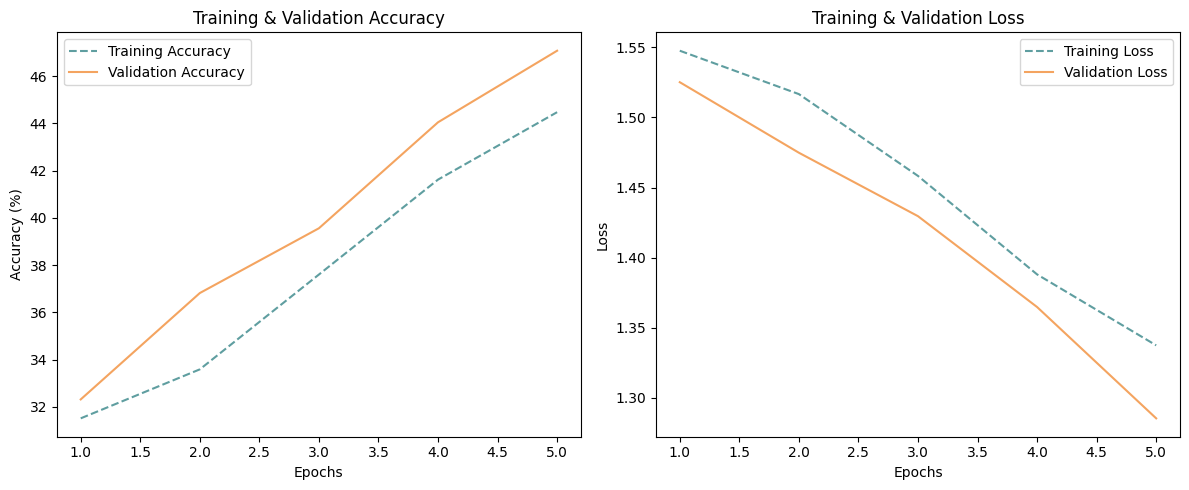

In [70]:
model = CNN(num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

num_epochs = 5


history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(num_epochs):
    # ===== TRAIN =====
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader_aug_e, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        bs = labels.size(0)
        running_loss += loss.item() * bs
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += bs

    train_loss = running_loss / total
    train_acc = 100.0 * correct / total

    # ===== VAL =====
    val_loss, val_acc = evaluate_loader(model, val_loader_e, criterion)

    # ===== SAVE HISTORY =====
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%"
    )

# ===== PLOT =====
plot_training_history(history)


Les courbes d’apprentissage montrent une augmentation régulière de l’accuracy ainsi qu’une diminution de la loss sur les ensembles d’entraînement et de validation.
La performance en validation est systématiquement supérieure à celle observée en entraînement, ce qui s’explique par l’utilisation d’augmentations de données uniquement sur le jeu d’entraînement.
L’absence de divergence entre les courbes indique que le modèle ne présente pas d’overfitting et généralise correctement, bien que sa capacité reste limitée, ce qui explique un plafond de performance autour de 45–50 % d’accuracy. Augmenter le nombre d'epoch pourrait permettre d'améliorer les performances. 

In [24]:
for epoch in range(num_epochs):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader_e,desc=f"Epoch {epoch+1}/{num_epochs} [TEST]",leave=True):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            bs = labels.size(0)
            test_loss += loss.item() * bs
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += bs

    test_loss /= total
    test_acc = correct / total

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}"
    )


Epoch 1/10 [TEST]:  53%|███████████▌          | 195/370 [00:10<00:09, 18.39it/s]


KeyboardInterrupt: 

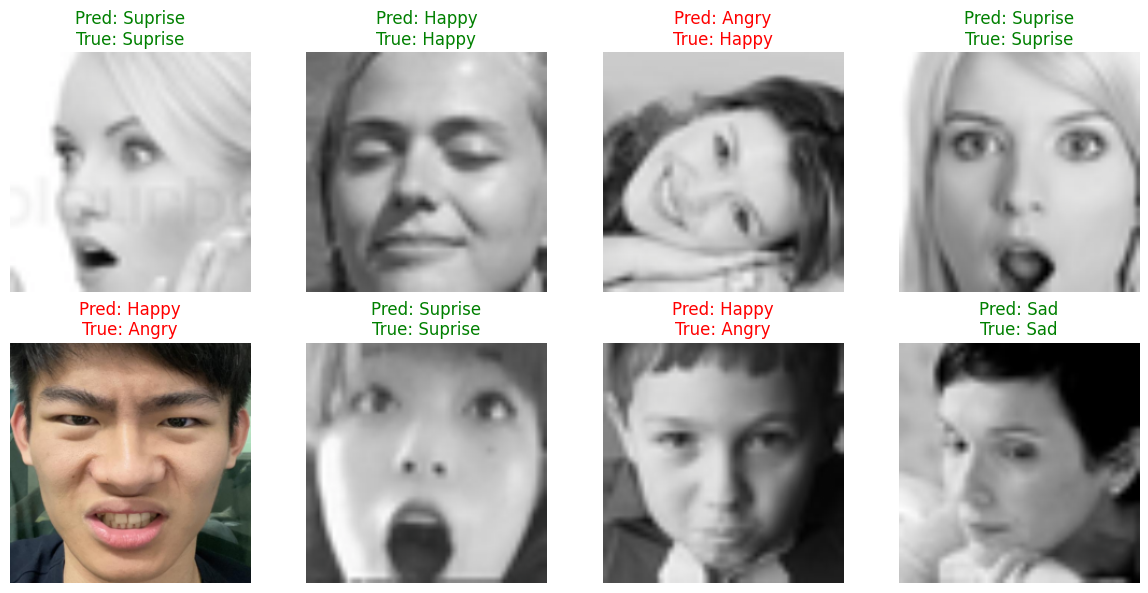

In [64]:
# Exemple de prédiction pour emotion
model.eval()
images, labels = next(iter(test_loader_e))
images = images.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Dé-normalisation (pour affichage)
mean = torch.tensor([0.485, 0.456, 0.406], device=images.device).view(1, 3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225], device=images.device).view(1, 3, 1, 1)

images_vis = (images * std + mean).clamp(0, 1).detach().cpu()
preds_cpu = preds.detach().cpu()
labels_cpu = labels.detach().cpu()

n = min(8, images_vis.size(0))
plt.figure(figsize=(12, 6))
for idx in range(n):
    plt.subplot(2, 4, idx + 1)
    plt.imshow(images_vis[idx].permute(1, 2, 0))

    pred_name = idx_to_emotion[int(preds_cpu[idx])]
    true_name = idx_to_emotion[int(labels_cpu[idx])]

    color = "green" if preds_cpu[idx] == labels_cpu[idx] else "red"
    plt.title(f"Pred: {pred_name}\nTrue: {true_name}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()



Il faudrait comparer la performance avec celle faite sans entraînement, pour voir si la partie "train" est vraiment productive. Cela nous permettra de voir de quoi on part avec le CNN comparé au ViT. 

On observe ici que la même architecture entraînée de CNN semble donner des résultats très probants (avec des accuracy autour de 97%) pour le dataset de fleurs comme pour celui des émotions. Nous allons cependant continuer notre étude de modèle en testant cette fois ci avec un ViT afin de voir si l'on obtient de meilleures performances.

In [80]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_e:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)


<Figure size 800x800 with 0 Axes>

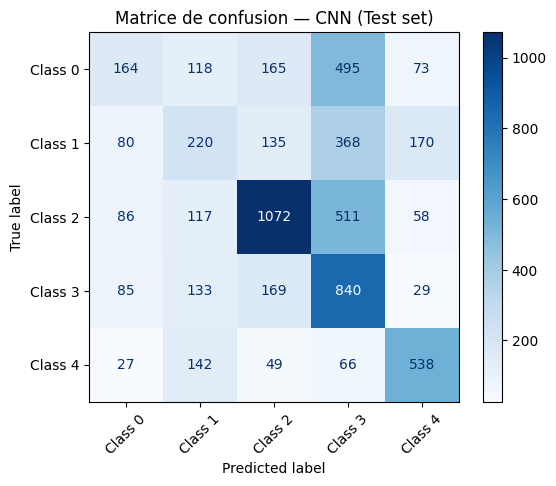

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=idx_to_emotion
)

plt.figure(figsize=(8, 8))
disp.plot(
    cmap="Blues",
    xticks_rotation=45,
    values_format="d"
)
plt.title("Matrice de confusion — CNN (Test set)")
plt.show()


## Entrainement du CNN pour le dataset Art

Epoch 1/10: 100%|█████████████████████████████| 423/423 [00:20<00:00, 20.93it/s]


Epoch 1/10 | Train Loss: 3.4466 Acc: 13.82% | Val Loss: 3.2640 Acc: 15.27%


Epoch 2/10: 100%|█████████████████████████████| 423/423 [00:24<00:00, 17.38it/s]


Epoch 2/10 | Train Loss: 3.1814 Acc: 18.35% | Val Loss: 3.0626 Acc: 20.59%


Epoch 3/10: 100%|█████████████████████████████| 423/423 [00:19<00:00, 21.36it/s]


Epoch 3/10 | Train Loss: 2.9856 Acc: 22.28% | Val Loss: 2.9054 Acc: 24.02%


Epoch 4/10: 100%|█████████████████████████████| 423/423 [00:20<00:00, 21.04it/s]


Epoch 4/10 | Train Loss: 2.8398 Acc: 25.06% | Val Loss: 2.7766 Acc: 27.69%


Epoch 5/10: 100%|█████████████████████████████| 423/423 [00:24<00:00, 17.42it/s]


Epoch 5/10 | Train Loss: 2.7385 Acc: 26.95% | Val Loss: 2.7320 Acc: 26.98%


Epoch 6/10: 100%|█████████████████████████████| 423/423 [00:20<00:00, 21.15it/s]


Epoch 6/10 | Train Loss: 2.6679 Acc: 28.54% | Val Loss: 2.6964 Acc: 27.81%


Epoch 7/10: 100%|█████████████████████████████| 423/423 [00:19<00:00, 21.94it/s]


Epoch 7/10 | Train Loss: 2.6050 Acc: 29.09% | Val Loss: 2.6255 Acc: 29.70%


Epoch 8/10: 100%|█████████████████████████████| 423/423 [00:20<00:00, 20.47it/s]


Epoch 8/10 | Train Loss: 2.5600 Acc: 30.88% | Val Loss: 2.6640 Acc: 29.59%


Epoch 9/10: 100%|█████████████████████████████| 423/423 [00:22<00:00, 18.84it/s]


Epoch 9/10 | Train Loss: 2.5198 Acc: 31.66% | Val Loss: 2.5872 Acc: 30.65%


Epoch 10/10: 100%|████████████████████████████| 423/423 [00:19<00:00, 21.30it/s]


Epoch 10/10 | Train Loss: 2.4839 Acc: 32.13% | Val Loss: 2.5202 Acc: 32.07%


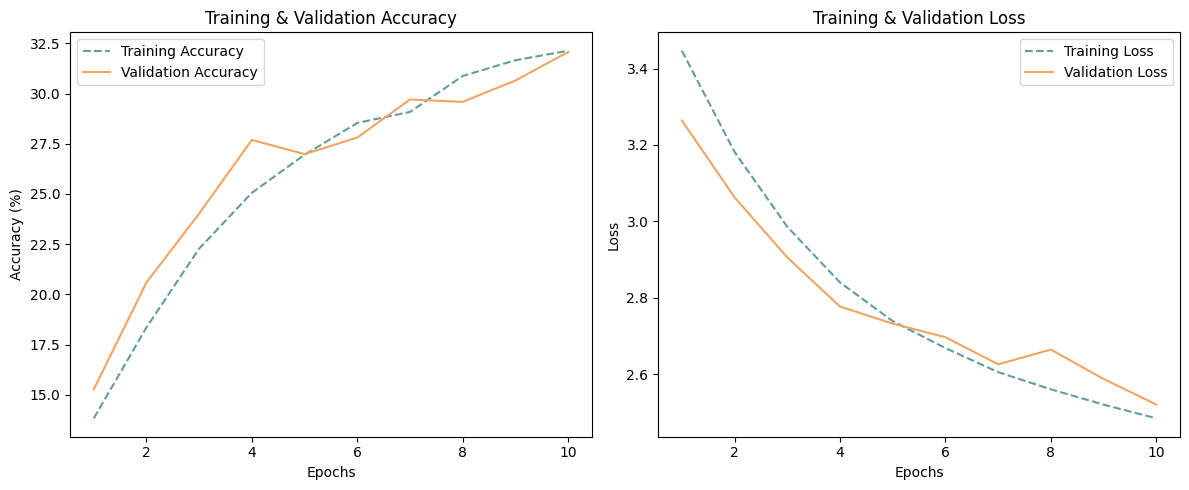

In [22]:
model = CNN(num_classes=50).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

num_epochs = 10


history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(num_epochs):
    # ===== TRAIN =====
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader_a, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        bs = labels.size(0)
        running_loss += loss.item() * bs
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += bs

    train_loss = running_loss / total
    train_acc = 100.0 * correct / total

    # ===== VAL =====
    val_loss, val_acc = evaluate_loader(model, val_loader_a, criterion)

    # ===== SAVE HISTORY =====
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%"
    )

# ===== PLOT =====
plot_training_history(history)


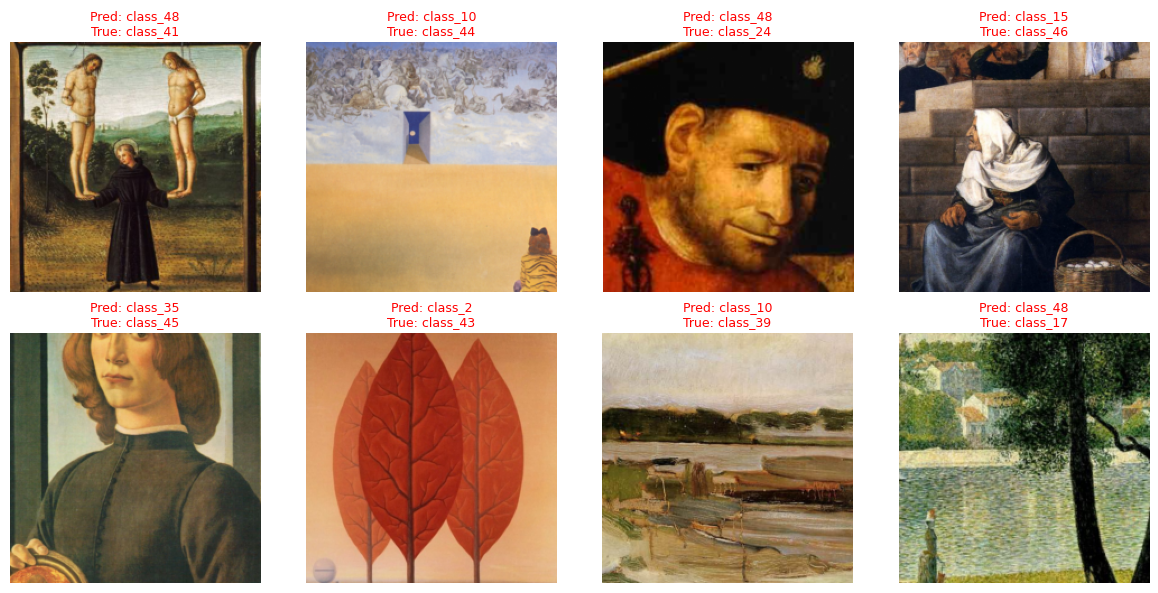

In [89]:
model.eval()
images, labels = next(iter(test_loader_a))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# mapping classes art (ImageFolder / Subset(ImageFolder))
ds = test_loader_a.dataset
if hasattr(ds, "classes"):
    idx_to_artist = ds.classes
elif hasattr(ds, "dataset") and hasattr(ds.dataset, "classes"):
    idx_to_artist = ds.dataset.classes
else:
    idx_to_artist = [f"class_{i}" for i in range(outputs.shape[1])]

# Dé-normalisation (CPU pour affichage)
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

images_vis = (images.detach().cpu() * std + mean).clamp(0, 1)
preds_cpu = preds.detach().cpu()
labels_cpu = labels.detach().cpu()

n = min(8, images_vis.size(0))
plt.figure(figsize=(12, 6))
for idx in range(n):
    plt.subplot(2, 4, idx + 1)
    plt.imshow(images_vis[idx].permute(1, 2, 0))

    pred_name = idx_to_artist[int(preds_cpu[idx])]
    true_name = idx_to_artist[int(labels_cpu[idx])]

    color = "green" if preds_cpu[idx] == labels_cpu[idx] else "red"
    plt.title(f"Pred: {pred_name}\nTrue: {true_name}", color=color, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()



# Implémentation du ViT

Les transformers ont initialement étaient inventés pour des problèmes NLP mais on peut aussi l'utiliser -comme ici- pour de la classification d'images. 

On commence par le *patch embedding* : l’image est découpée en patchs non chevauchants (par exemple de taille 16×16×3). Chaque patch est ensuite aplati en un vecteur 1D, que l’on peut appeler $patch_{flat}$. Ainsi, pour chaque patch, on obtient un vecteur de taille fixe $N$ (correspondant au nombre total de pixels multiplié par le nombre de canaux).
Cependant, ce vecteur brut n’est pas encore dans l’espace de représentation utilisé par le Transformer. Le Transformer travaille avec une dimension d’embedding fixe $D$ (par exemple, pour $ViT-Base$, $D=768$).
Pour passer de $N$ à $D$, on applique une projection linéaire : chaque vecteur $patch_{flat}$ est multiplié par une matrice de poids apprenables $W \in \mathbb{R}^{N \times D}$.
Cette transformation produit un vecteur de dimension $D$ pour chaque patch. Ces vecteurs sont alors adaptés pour être traités par le Transformer : ils capturent de manière efficace des informations sur les formes, textures, couleurs, etc., dans un espace où le modèle peut apprendre des relations globales entre les patchs.

**Qu'est ce que la matrice $W$?**

La matrice $W \in \mathbb{R}^{N \times D}$ sert à transformer un patch brut en un embedding de dimension $D$. Chaque colonne de $W$ correspond à une feature ou un filtre que le modèle apprend à détecter dans un patch, tandis que chaque ligne correspond à un pixel spécifique du patch. Cette matrice est apprise par backpropagation lors de l’entraînement. Ainsi, $W$ apprend à produire des vecteurs qui contiennent les informations visuelles les plus pertinentes pour les couches Transformer qui suivent. Chaque valeur de ces vecteurs après projection est appelée une activation. On appellera par la suite ces nouveaux vecteurs $patch_{projected}$.

**Token CLS** 

A la suite du *patch embedding*, un token spécial appelé token de classification (noté $[CLS]$) est ajouté au début de la séquence. Ce token est un vecteur apprenable, de même dimension que les $patch_{projected}$. Contrairement aux autres tokens, il ne correspond à aucun patch de l’image. Son rôle est d’agréger, via les mécanismes d’auto-attention du Transformer, les informations provenant de l’ensemble des patchs. Après le passage dans tous les blocs de l’encodeur, l’état final du token $[CLS]$ est utilisé comme représentation globale de l’image et sert d’entrée à la couche de classification finale.

**Encodage positionnel**

Après cette étape, un *encodage positionnel* est ajouté à chaque embedding de patch afin de préserver la structure spatiale de l’image originale. Ces encodages permettent au modèle de capturer les relations spatiales entre les patchs, de manière analogue à la façon dont les Transformers en traitement du langage naturel encodent la position des mots dans une phrase. Dans les Vision Transformers, les encodages positionnels peuvent être soit appris pendant l’entraînement, soit prédéfinis (fixes). La plupart des implémentations modernes utilisent des encodages positionnels appris, ce qui permet au modèle d’adapter dynamiquement les représentations des positions pour la tâche spécifique.

Une fois cette étape réalisée, les patchs sont incorporés dans l’encodeur, qui est composé de $L$ blocs identiques. Dans chaque bloc, on retrouve successivement un LayerNorm, suivi d’une Multi-Head Self-Attention, puis d’une connexion résiduelle (Add & Skip), ensuite un second LayerNorm et enfin un Feed-Forward Network. Après avoir traversé tous les blocs de l’encodeur, on obtient un embedding final qui est ensuite utilisé pour effectuer la classification finale de l’image.

**Explication du LayerNorm**

Chaque *activation* $x_i$, ’est-à-dire chaque valeur des vecteurs $patch_projected$ est d’abord normalisée en soustrayant la moyenne et en divisant par l’écart-type, ce qui donne $\hat{x_i}$. Ensuite, pour chaque valeur normalisée, on ajoute un gain et un biais, qui sont des paramètres appris par le modèle, de manière à obtenir $\gamma * \hat{x_i} + \beta$. Cette opération assure que toutes les dimensions des vecteurs sont centrées autour de zéro et présentent une variance similaire, ce qui permet aux vecteurs d’être “équilibrés”. Cette normalisation facilite le travail du Transformer, en lui permettant de mieux combiner les informations et en évitant que certaines valeurs deviennent trop grandes ou trop petites pendant l’entraînement.

**Explication du Multi-Head Attention**

Après le LayerNorm, chaque token a une taille $D$.

L’attention permet à chaque token de regarder tous les autres tokens et de décider quelles informations il doit prendre en compte pour enrichir sa propre représentation. À chaque itération (bloc encodeur), les tokens sont mis à jour. Chaque patch doit comprendre son contexte, c’est-à-dire comment il se rapporte aux autres patches. On ne prend pas tout le contenu des autres tokens de manière égale : chaque token est pondéré selon son importance pour le token courant.

*Objectif de l’attention* : pour chaque token, décider quelles informations des autres tokens sont importantes.

Pour cela, on utilise les vecteurs $Query$ $(Q)$, $Key$ $(K)$ et $Value$ $(V)$ :


- $Q$ : ce que ce token cherche chez les autres
- $K$ : ce que chaque token propose (peut être trouvé)
- $V$ : l’information que chaque token transporte réellement. V contient donc le contenu que le token peut transmettre aux autres tokens.


Les matrices $W^Q$ , $W^K$ , $W^V$ sont initialisées de manière aléatoire (souvent avec une distribution normale) et sont mises à jour pendant l’entraînement via rétropropagation. 

Ensuite, la matrice de tous les tokens est projetée via les matrices apprises $W^Q$ , $W^K$ , $W^V$ pour obtenir les $Q$, $K$ et $V$ de tous les tokens en parallèle.

On multiplie la matrice complète de tokens par $W^Q$ , $W^K$ , $W^V$ pour obtenir tous les $Q$, $K$ et $V$ en une seule opération matricielle :

$$
Q = X W^Q, \quad K = X W^K, \quad V = X W^V
$$

Après la projection, on obtient trois matrices : 
$$
Q, K, V \in \mathbb{R}^{N \times D}
$$
où chaque ligne correspond à un token et contient son vecteur $Q$, $K$ ou $V$.

- La ligne $i$ de $Q$ correspond au vecteur de ce token qui encode ce qu’il cherche chez les autres.  
- La ligne $i$ de $K$ correspond au vecteur de ce token qui encode ce qu’il propose aux autres.  
- La ligne $i$ de $V$ correspond au vecteur de ce token qui encode l’information qu’il transmet réellement.



On calcule alors le score d’attention à partir de la similarité entre $Q$ et $K$. Le résultat est une matrice $\mathbb{R}^{N \times N}$, où chaque ligne correspond à un token et chaque colonne à l’importance des autres tokens pour ce token. On applique ensuite un softmax aux scores pour obtenir les poids d’attention, qui indiquent combien chaque token doit prendre en compte chaque autre token.

Les tokens sont ensuite mis à jour en combinant les valeurs V des autres tokens pondérées par les poids d’attention. Le résultat est que chaque token devient une combinaison pondérée de tous les tokens, enrichie du contexte global.

Chaque token contient donc ses propres informations plus un mélange pondéré des informations des autres tokens, ce qui permet au ViT de capturer des relations globales entre les patches.

En résumé, le Multi-Head Attention est un mécanisme qui permet à chaque patch de “regarder” tous les autres patches, avec plusieurs heads apprenant différents types de relations, afin d’enrichir chaque token avec un contexte global.


**Explication du Add & Skip**

On ajoute l’entrée d’une sous-couche à sa sortie, c’est-à-dire que l’entrée du LayerNorm est ajoutée à la sortie de la Multi-Head Attention, et de la même manière après le Feed-Forward. Cette opération permet au bloc de n’apprendre que la différence par rapport à l’entrée, plutôt que de recalculer entièrement la transformation. De plus, dans les réseaux profonds, il peut survenir des problèmes de vanishing gradients ; l’ajout de l’entrée garantit que le gradient peut toujours circuler directement de la sortie vers l’entrée. 

En résumé, le mécanisme d’Add & Skip rend l’apprentissage plus stable et efficace, en laissant passer l’information originale tout en ajoutant uniquement ce que la sous-couche apprend de nouveau.

**Explication du Feed-Forward**

Ici chaque token est traité individuellement. Le FFN est un MLP appliqué séparément à chaque token. De manière plus détaillée, le MLP va projeté le vecteur dans une dimension plus grande afin de crée plus de liberté pour combiner et recombiner les informations. Puis il va appliquer une fonction d'activation non linéaire GELU ce qui permet au réseau de modéliser des transformations complexes. Enfin, il va projetter de nouveaux les vecteurs dans la dimension de base $D$ pour que le Add & Skip fonctionne correctement.


Après l'encodeur, les différents vecteurs sont passés dans une couche linéaire pour produire les logits de classification. Ces logits sont ensuite passé dans une fonction softmax pour faire la prédiction de classes.


Dans cette étape, chaque token est traité individuellement. Le Feed-Forward Network (FFN) est un MLP appliqué séparément à chaque token. Plus en détail, le MLP projette d’abord le vecteur dans une dimension plus grande, ce qui offre davantage de liberté pour combiner et recombiner les informations. Ensuite, une fonction d’activation non linéaire GELU est appliquée, permettant au réseau de modéliser des transformations complexes. Enfin, les vecteurs sont projetés de nouveau dans la dimension de base $D$ afin que le mécanisme d’Add & Skip fonctionne correctement.

Après le passage dans l’encodeur, les différents vecteurs sont envoyés dans une couche linéaire pour produire les logits de classification. Ces logits sont ensuite passés dans une fonction softmax pour générer la prédiction finale des classes.

## Implémentation du Vit-B/16 

In [13]:
num_classes = 5
model = ViT(num_classes=num_classes)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
images, labels = images.to(device), labels.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

NameError: name 'ViT' is not defined

In [57]:
num_epochs = 5###

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
   for images, labels in tqdm(train_loader_e, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# Implémentation du Vit-B/16 par transfer learning et fine-tuning

Cette architecture est déjà implémentée par PyTorch via la librairie torchvision, nous n'avons donc pas besoin de l'implémenter à la main. Il est possible d'utiliser directement le modèle pré-entrainé sur ImageNet_1k (donc avec les poids déjà entrainés) avec les poids *SWAG_LINEAR_V1* qui est une version optimisée pour un fine-tuning rapide et où seule la couche linéaire peut être entraînée. 
De plus, nous avons choisi ces poids là car les poids *IMAGENET1K_V1* donne une accuracy légèrement plus petite.
Ici on gèle les poids sauf ceux de la couche linéaire afin d'adapter le modèle à notre dataset qui a seulement 5 classes

Toutes ces informaitons ont été prises via la documentation de pytorch : https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html 

Pour ce modèle, $patch_{size}=16$.

**A Faire**

on entraine d'abord le classifieur donc on gele tout, on entraine avec un pas 1e-3 c'est bine puis on degele la tete et on re entraine avec un mini pas genre 10-6 ou 5(voir tp chien chat)

en gros le modele entraine pas d'apers les graphes du abs

In [28]:
weights = ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1
model = vit_b_16(weights=None) #on ne charge pas les poids ici pour ne pas avoir de problèmes avec le nombre de classes


num_classes = 5

#on réduit graduellement le nombre de classes pour ne pas rendre le modèle instable
# 768 = dimension du token CLS et de l'embedding
model.heads.head = nn.Sequential(
    nn.Linear(768, 500),  
    nn.ReLU(),
    nn.Linear(500, 256),  
    nn.ReLU(),
    nn.Linear(256, 64),   
    nn.ReLU(),
    nn.Linear(64, 5)      
    )

#Geler TOUT le modèle
for param in model.parameters():
    param.requires_grad = False

#Dégeler UNIQUEMENT la vraie tête
#for param in model.heads.head.parameters():
 #   param.requires_grad = True

# Charger les poids du backbone uniquement
state_dict = weights.get_state_dict(progress=True)

# Supprimer les poids de la tête linéaire pour éviter le conflit
del state_dict["heads.head.weight"]
del state_dict["heads.head.bias"]

#Verification
print(model.heads.head.weight.requires_grad)

model.load_state_dict(state_dict, strict=False) #charge les poids du modèle -> transfer learning

AttributeError: 'Sequential' object has no attribute 'weight'

# On gèle le backbone et on entraine le classifieur (la tete)

In [29]:
#VRAIE CORRECTION

weights = ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1
model = vit_b_16(weights=None)
num_classes = 5

# Créer le nouveau classifieur
model.heads.head = nn.Sequential(
    nn.Linear(768, 500), nn.ReLU(),
    nn.Linear(500, 256), nn.ReLU(),
    nn.Linear(256, 64), nn.ReLU(),
    nn.Linear(64, num_classes)
)

# Charger les poids du backbone
state_dict = weights.get_state_dict(progress=True)
del state_dict["heads.head.weight"]
del state_dict["heads.head.bias"]
model.load_state_dict(state_dict, strict=False)

# Geler tout
for param in model.parameters():
    param.requires_grad = False

# Dégeler le classifieur
for param in model.heads.head.parameters():
    param.requires_grad = True

# Optimizer pour le classifieur uniquement
optimizer_phase1 = torch.optim.Adam(model.heads.head.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Entrainement

In [30]:
# --- Fonction pour prédiction / évaluation ---
def evaluate_loader(model, loader, criterion):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(loader)
    acc = 100 * correct / total
    return avg_loss, acc


# --- Fonction pour tracer le training ---
def plot_training_history(history):
    """
    history: dictionnaire avec
        history['train_loss'], history['val_loss'], 
        history['train_acc'], history['val_acc']
    """
    epochs = range(1, len(history['train_loss'])+1)

    plt.figure(figsize=(12,5))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_acc'], color='cadetblue', linestyle="--", label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], color='sandybrown', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_loss'], color='cadetblue', linestyle="--", label='Training Loss')
    plt.plot(epochs, history['val_loss'], color='sandybrown', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/20: 100%|███████████████████████████| 2955/2955 [11:49<00:00,  4.16it/s]


Epoch 1 took 757.31 sec


Epoch 2/20: 100%|███████████████████████████| 2955/2955 [11:52<00:00,  4.15it/s]


Epoch 2 took 756.91 sec


Epoch 3/20: 100%|███████████████████████████| 2955/2955 [11:53<00:00,  4.14it/s]


Epoch 3 took 758.11 sec


Epoch 4/20: 100%|███████████████████████████| 2955/2955 [11:54<00:00,  4.14it/s]


Epoch 4 took 758.51 sec


Epoch 5/20: 100%|███████████████████████████| 2955/2955 [11:54<00:00,  4.14it/s]


Epoch 5 took 759.03 sec


Epoch 6/20: 100%|███████████████████████████| 2955/2955 [11:53<00:00,  4.14it/s]


Epoch 6 took 757.48 sec


Epoch 7/20: 100%|███████████████████████████| 2955/2955 [11:52<00:00,  4.14it/s]


Epoch 7 took 758.15 sec


Epoch 8/20: 100%|███████████████████████████| 2955/2955 [11:56<00:00,  4.12it/s]


Epoch 8 took 761.23 sec


Epoch 9/20: 100%|███████████████████████████| 2955/2955 [11:59<00:00,  4.11it/s]


Epoch 9 took 763.94 sec


Epoch 10/20: 100%|██████████████████████████| 2955/2955 [11:55<00:00,  4.13it/s]


Epoch 10 took 759.58 sec


Epoch 11/20: 100%|██████████████████████████| 2955/2955 [11:54<00:00,  4.14it/s]


Epoch 11 took 758.54 sec


Epoch 12/20: 100%|██████████████████████████| 2955/2955 [11:54<00:00,  4.13it/s]


Epoch 12 took 761.33 sec


Epoch 13/20: 100%|██████████████████████████| 2955/2955 [12:17<00:00,  4.01it/s]


Epoch 13 took 782.66 sec


Epoch 14/20: 100%|██████████████████████████| 2955/2955 [12:08<00:00,  4.05it/s]


Epoch 14 took 773.19 sec


Epoch 15/20: 100%|██████████████████████████| 2955/2955 [12:00<00:00,  4.10it/s]


Epoch 15 took 765.10 sec


Epoch 16/20: 100%|██████████████████████████| 2955/2955 [11:57<00:00,  4.12it/s]


Epoch 16 took 761.89 sec


Epoch 17/20: 100%|██████████████████████████| 2955/2955 [11:53<00:00,  4.14it/s]


Epoch 17 took 757.36 sec


Epoch 18/20: 100%|██████████████████████████| 2955/2955 [11:56<00:00,  4.12it/s]


Epoch 18 took 761.13 sec


Epoch 19/20: 100%|██████████████████████████| 2955/2955 [11:55<00:00,  4.13it/s]


Epoch 19 took 759.13 sec


Epoch 20/20: 100%|██████████████████████████| 2955/2955 [11:57<00:00,  4.12it/s]


Epoch 20 took 761.36 sec


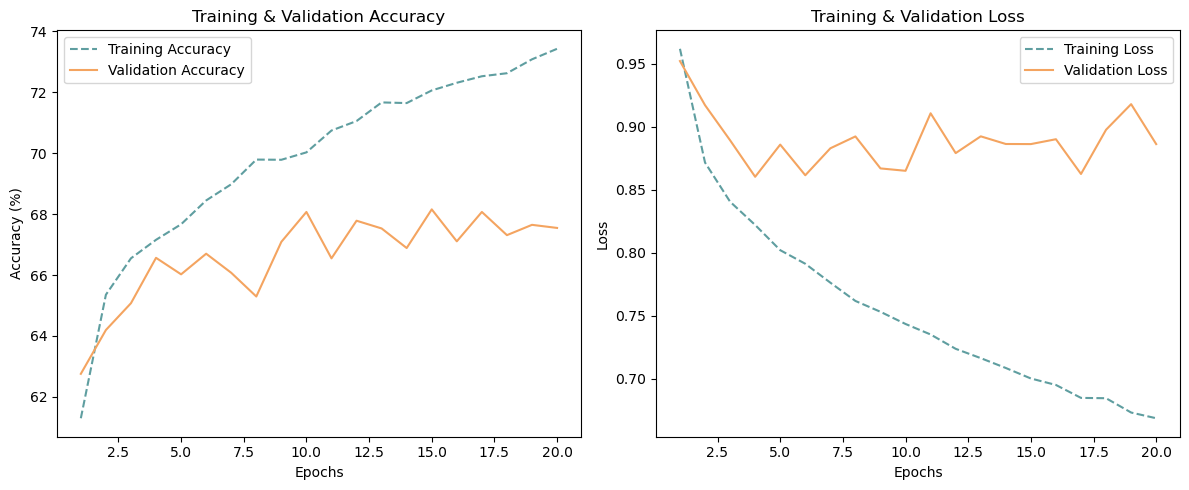

In [31]:
# Dictionnaire pour stocker l’historique
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.heads.parameters(), lr=1e-3)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
 
#best_val_acc = 0.0    
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    t_epoch = time.time()

    for images, labels in tqdm(train_loader_aug_e, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calcul de l'accuracy train
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader_aug_e)
    train_acc = 100 * correct / total

    # Validation
    val_loss, val_acc = evaluate_loader(model, val_loader_e, criterion)
    # Stocker l'historique
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    t_epoch = time.time() - t_epoch
    print(f"Epoch {epoch+1} took {t_epoch:.2f} sec")
    #if val_acc > best_val_acc:
     #   best_val_acc = val_acc
      #  torch.save(model.state_dict(), "best_model.pth")
       # print("✅ Meilleur modèle sauvegardé")



plot_training_history(history)

In [32]:
torch.save(model.state_dict(), "model_head_training.pth")


# On dégèle tout + entrainement

In [ ]:
# Dégeler TOUT
for param in model.parameters():
    param.requires_grad = True

# Optimizer pour TOUT avec petit learning rate
optimizer_phase2 = torch.optim.Adam(model.parameters(), lr=1e-6)

In [ ]:
# Dictionnaire pour stocker l’historique
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

num_epochs = 20
criterion = nn.CrossEntropyLoss()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
 
#best_val_acc = 0.0    
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    t_epoch = time.time()

    for images, labels in tqdm(train_loader_aug_e, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer_phase2.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_phase2.step()
        running_loss += loss.item()

        # Calcul de l'accuracy train
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader_aug_e)
    train_acc = 100 * correct / total

    # Validation
    val_loss, val_acc = evaluate_loader(model, val_loader_e, criterion)
    # Stocker l'historique
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    t_epoch = time.time() - t_epoch
    print(f"Epoch {epoch+1} took {t_epoch:.2f} sec")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Meilleur modèle sauvegardé")



plot_training_history(history)

# ----

In [14]:
# tentative corrigée 
import torch.nn as nn
from torchvision.models import vit_b_16, ViT_B_16_Weights

# On mets les poids ImageNet
weights = ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1

# On prends l'archiotecture mais sans la tête
model = vit_b_16(weights=None)

num_classes = 5

# Nouvelle tête de classification (pour pas que ça soit trop brusqye (tu disais "chaud de passser de 700 a 5) ducoup j'essaye de corriger ça mais je sais pas si c'est au bon endroit)
model.heads.head = nn.Sequential(
    nn.Linear(768, 500),
    nn.ReLU(),
    nn.Linear(500, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, num_classes)
)

# Charger le backbone déhà pré entraôné 
state_dict = weights.get_state_dict(progress=True)

# Supprimer l'ancienne tête ImageNet
del state_dict["heads.head.weight"]
del state_dict["heads.head.bias"]

model.load_state_dict(state_dict, strict=False)


_IncompatibleKeys(missing_keys=['heads.head.0.weight', 'heads.head.0.bias', 'heads.head.2.weight', 'heads.head.2.bias', 'heads.head.4.weight', 'heads.head.4.bias', 'heads.head.6.weight', 'heads.head.6.bias'], unexpected_keys=[])

In [15]:
# Geler tout le modèle
for param in model.parameters():
    param.requires_grad = False

# puis dégeler la tête
for param in model.heads.head.parameters():
    param.requires_grad = True

# Vérification
print("Phase 1 avec paramètres entraînables :")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


Phase 1 avec paramètres entraînables :
heads.head.0.weight
heads.head.0.bias
heads.head.2.weight
heads.head.2.bias
heads.head.4.weight
heads.head.4.bias
heads.head.6.weight
heads.head.6.bias


In [16]:
optimizer = torch.optim.AdamW(
    model.heads.head.parameters(),
    lr=1e-3
)

In [17]:
for name, param in model.named_parameters():
    if (
        name.startswith("heads.head")
        or "encoder.ln" in name
        or "encoder.layers.11" in name  # dernier bloc ViT
    ):
        param.requires_grad = True


In [18]:
print("Phase 2 avec paramètres entraînables :")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


Phase 2 avec paramètres entraînables :
encoder.ln.weight
encoder.ln.bias
heads.head.0.weight
heads.head.0.bias
heads.head.2.weight
heads.head.2.bias
heads.head.4.weight
heads.head.4.bias
heads.head.6.weight
heads.head.6.bias


In [19]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-6  # ou 5e-6
)
criterion = nn.CrossEntropyLoss()

Cela veut dire qu'on entraîne bien la couche linéaire: ce qu'on veut.

In [20]:
optimizer = optim.Adam(model.heads.head.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

### Entraînement pour le dataset Emotions

On implémete les mêmes fonctions que dans le projet 1.

In [21]:
# --- Fonction pour prédiction / évaluation ---
def evaluate_loader(model, loader, criterion):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(loader)
    acc = 100 * correct / total
    return avg_loss, acc


# --- Fonction pour tracer le training ---
def plot_training_history(history):
    """
    history: dictionnaire avec
        history['train_loss'], history['val_loss'], 
        history['train_acc'], history['val_acc']
    """
    epochs = range(1, len(history['train_loss'])+1)

    plt.figure(figsize=(12,5))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_acc'], color='cadetblue', linestyle="--", label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], color='sandybrown', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_loss'], color='cadetblue', linestyle="--", label='Training Loss')
    plt.plot(epochs, history['val_loss'], color='sandybrown', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [27]:
# Dictionnaire pour stocker l’historique
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.heads.parameters(), lr=1e-3)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
 
best_val_acc = 0.0    
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    t_epoch = time.time()

    for images, labels in tqdm(train_loader_aug_e, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calcul de l'accuracy train
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader_aug_e)
    train_acc = 100 * correct / total

    # Validation
    val_loss, val_acc = evaluate_loader(model, val_loader_e, criterion)
    # Stocker l'historique
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    t_epoch = time.time() - t_epoch
    print(f"Epoch {epoch+1} took {t_epoch:.2f} sec")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Meilleur modèle sauvegardé")


torch.save(model.state_dict(), "model_final.pth")

plot_training_history(history)

Epoch 1/20:  25%|███████                     | 745/2955 [03:03<09:05,  4.05it/s]


KeyboardInterrupt: 

# Pourquoi autant d'overfitting? Pourquoi accuracy de merde avec autant d'epoch?????

In [51]:
 print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_e):.4f}")

Epoch 1, Loss: 0.0284


In [14]:
for name in model.state_dict().keys():
    print(name)

class_token
conv_proj.weight
conv_proj.bias
encoder.pos_embedding
encoder.layers.encoder_layer_0.ln_1.weight
encoder.layers.encoder_layer_0.ln_1.bias
encoder.layers.encoder_layer_0.self_attention.in_proj_weight
encoder.layers.encoder_layer_0.self_attention.in_proj_bias
encoder.layers.encoder_layer_0.self_attention.out_proj.weight
encoder.layers.encoder_layer_0.self_attention.out_proj.bias
encoder.layers.encoder_layer_0.ln_2.weight
encoder.layers.encoder_layer_0.ln_2.bias
encoder.layers.encoder_layer_0.mlp.0.weight
encoder.layers.encoder_layer_0.mlp.0.bias
encoder.layers.encoder_layer_0.mlp.3.weight
encoder.layers.encoder_layer_0.mlp.3.bias
encoder.layers.encoder_layer_1.ln_1.weight
encoder.layers.encoder_layer_1.ln_1.bias
encoder.layers.encoder_layer_1.self_attention.in_proj_weight
encoder.layers.encoder_layer_1.self_attention.in_proj_bias
encoder.layers.encoder_layer_1.self_attention.out_proj.weight
encoder.layers.encoder_layer_1.self_attention.out_proj.bias
encoder.layers.encoder_lay

### Evaluation du modèle

In [1]:
import random

model.eval()
data_iter = iter(test_loader_e)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

class_names = full_dataset_emotions.classes  # liste des classes ImageFolder

# Choisir 4 indices aléatoires dans ce batch
rand_indices = random.sample(range(batch_size), 4)

plt.figure(figsize=(12,6))
for i, idx in enumerate(rand_indices):
    plt.subplot(2,4,i+1)
    img = images[idx].cpu()
    # undo normalisation
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    img = img.clamp(0,1)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

test_loss, test_acc = evaluate_loader(model, test_loader_e, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")



NameError: name 'model' is not defined

In [17]:
train_loader = DataLoader(
    train_dataset_aug_e,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset_e,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset_e,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

images, labels = next(iter(train_loader))
print("Batch OK :", images.shape, labels.shape)


Batch OK : torch.Size([16, 3, 224, 224]) torch.Size([16])


In [18]:
model = vit_b_16(weights="IMAGENET1K_V1")

num_features = model.heads.head.in_features
num_classes = len(full_dataset_emotions.classes)

model.heads.head = nn.Linear(num_features, num_classes)
model = model.to(device)


In [19]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.5
)


In [20]:
def train_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


def eval_epoch(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Eval", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


In [21]:
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = eval_epoch(model, val_loader)

    print(f"Train | Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   | Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vit_emotions.pth")
        print("✅ Modèle sauvegardé")



Epoch 1/10


KeyboardInterrupt: 

## Tentative Noémie du ViT

In [3]:
!pip install einops

   ---------------------------------------- 0.0/64.4 kB ? eta -:--:--
   -------------------------------------- - 61.4/64.4 kB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 64.4/64.4 kB 1.2 MB/s eta 0:00:00


Taille train : 47279 ( 80.0 % )
Taille validation : 5910 ( 10.0 % )
Taille test : 5910 ( 10.0 % )
                                                image  class
0                                         Angry\0.png      0
1                                         Angry\1.png      0
2                                        Angry\10.png      0
3                                     Angry\10002.png      0
4                                  Angry\10005903.png      0
...                                               ...    ...
59094  Suprise\vitaly-gariev-H58NsPHohrc-unsplash.jpg      4
59095  Suprise\vitaly-gariev-TGOnv4LoawM-unsplash.jpg      4
59096  Suprise\vitaly-gariev-YP1TpFgARZ0-unsplash.jpg      4
59097  Suprise\vitaly-gariev-bIageEhoicE-unsplash.jpg      4
59098  Suprise\vitaly-gariev-bbDCO1g-c64-unsplash.jpg      4

[59099 rows x 2 columns]


TypeError: pic should be Tensor or ndarray. Got <class 'str'>.

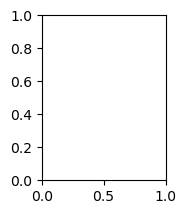

In [11]:
import torch
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

to_tensor = [Resize((144, 144)), ToTensor()]

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
        return image, target

def show_images(images, num_samples=40, cols=8):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    idx = int(len(dataset) / num_samples)
    print(images)
    for i, img in enumerate(images):
        if i % idx == 0:
            plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
            plt.imshow(to_pil_image(img[0]))

# Récupération du dataset émotions :

#Chargement du dataset
dataset_path = "emotions/Data"
full_dataset_emotions = datasets.ImageFolder(root=dataset_path)
idx_to_emotion = {v:k for k,v in full_dataset_emotions.class_to_idx.items()}

#Création d'un DataFrame à partir de ImageFolder
image_paths = [
    os.path.relpath(s[0], dataset_path) #transformation en chemin relatif
    for s in full_dataset_emotions.samples
]

labels = [s[1] for s in full_dataset_emotions.samples]

full_df_emotions = pd.DataFrame({'image': image_paths, 'class': labels})

#Calcul des tailles des différents bases
N_total = len(full_df_emotions)
#Entrainement : 80%
N_train = int(0.8 * N_total)
#Validation, Test : 10%, 10%
N_val_test = N_total - N_train
N_val = N_val_test // 2
N_test = N_val_test - N_val

print("Taille train :", N_train, f"( {N_train/N_total*100:.4} % )")
print("Taille validation :", N_val, f"( {N_val/N_total*100:.4} % )")
print("Taille test :", N_test, f"( {N_test/N_total*100:.4} % )")

# Split des différents sets 
train_df_e, val_test_df_e = train_test_split(
    full_df_emotions,
    train_size=N_train,
    stratify=full_df_emotions['class'], #garantit que la proportion de chaque classe est conservée dans train et val_test
    random_state=42
)

val_df_e, test_df_e = train_test_split(
    val_test_df_e,
    train_size=N_val,
    stratify=val_test_df_e['class'],
    random_state=42
)

dataset = full_df_emotions
show_images(dataset)

## Implémentation du DeiT

Comme pour le modèle précédent, il attend des images de taille 224x224 et chaque patch ets de taille 16x16.

Je degele la ciuche lineaire ainsi que les deux derniers blocs du modèle.

In [12]:
model2 = create_model('deit_tiny_patch16_224', pretrained=True, num_classes=5)

#On gèle les poids du modèle
for param in model2.parameters():
    param.requires_grad = False

for param in model2.head.parameters():  # dégele poids de la couche linéaire
    param.requires_grad = True

# Dégeler les derniers blocs
for i in [10, 11]:
    for param in model2.blocks[i].parameters():
        param.requires_grad = True


trainable_params = [name for name, param in model2.named_parameters() if param.requires_grad]
print("Paramètres entraînables :", trainable_params)


criterion = nn.CrossEntropyLoss()

# Optimizer sur la tête uniquement
#optimizer = optim.Adam(model2.head.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-4)


Paramètres entraînables : ['blocks.10.norm1.weight', 'blocks.10.norm1.bias', 'blocks.10.attn.qkv.weight', 'blocks.10.attn.qkv.bias', 'blocks.10.attn.proj.weight', 'blocks.10.attn.proj.bias', 'blocks.10.norm2.weight', 'blocks.10.norm2.bias', 'blocks.10.mlp.fc1.weight', 'blocks.10.mlp.fc1.bias', 'blocks.10.mlp.fc2.weight', 'blocks.10.mlp.fc2.bias', 'blocks.11.norm1.weight', 'blocks.11.norm1.bias', 'blocks.11.attn.qkv.weight', 'blocks.11.attn.qkv.bias', 'blocks.11.attn.proj.weight', 'blocks.11.attn.proj.bias', 'blocks.11.norm2.weight', 'blocks.11.norm2.bias', 'blocks.11.mlp.fc1.weight', 'blocks.11.mlp.fc1.bias', 'blocks.11.mlp.fc2.weight', 'blocks.11.mlp.fc2.bias', 'head.weight', 'head.bias']


In [13]:
for name in model2.state_dict().keys():
    print(name)

cls_token
pos_embed
patch_embed.proj.weight
patch_embed.proj.bias
blocks.0.norm1.weight
blocks.0.norm1.bias
blocks.0.attn.qkv.weight
blocks.0.attn.qkv.bias
blocks.0.attn.proj.weight
blocks.0.attn.proj.bias
blocks.0.norm2.weight
blocks.0.norm2.bias
blocks.0.mlp.fc1.weight
blocks.0.mlp.fc1.bias
blocks.0.mlp.fc2.weight
blocks.0.mlp.fc2.bias
blocks.1.norm1.weight
blocks.1.norm1.bias
blocks.1.attn.qkv.weight
blocks.1.attn.qkv.bias
blocks.1.attn.proj.weight
blocks.1.attn.proj.bias
blocks.1.norm2.weight
blocks.1.norm2.bias
blocks.1.mlp.fc1.weight
blocks.1.mlp.fc1.bias
blocks.1.mlp.fc2.weight
blocks.1.mlp.fc2.bias
blocks.2.norm1.weight
blocks.2.norm1.bias
blocks.2.attn.qkv.weight
blocks.2.attn.qkv.bias
blocks.2.attn.proj.weight
blocks.2.attn.proj.bias
blocks.2.norm2.weight
blocks.2.norm2.bias
blocks.2.mlp.fc1.weight
blocks.2.mlp.fc1.bias
blocks.2.mlp.fc2.weight
blocks.2.mlp.fc2.bias
blocks.3.norm1.weight
blocks.3.norm1.bias
blocks.3.attn.qkv.weight
blocks.3.attn.qkv.bias
blocks.3.attn.proj.wei

Epoch 1/20: 100%|███████████████████████████| 2955/2955 [04:39<00:00, 10.57it/s]


Epoch 1 took 313.70 sec


Epoch 2/20: 100%|███████████████████████████| 2955/2955 [02:23<00:00, 20.64it/s]


Epoch 2 took 158.10 sec


Epoch 3/20: 100%|███████████████████████████| 2955/2955 [02:28<00:00, 19.90it/s]


Epoch 3 took 164.06 sec


Epoch 4/20: 100%|███████████████████████████| 2955/2955 [02:23<00:00, 20.58it/s]


Epoch 4 took 160.17 sec


Epoch 5/20: 100%|███████████████████████████| 2955/2955 [02:31<00:00, 19.56it/s]


Epoch 5 took 167.96 sec


Epoch 6/20: 100%|███████████████████████████| 2955/2955 [02:34<00:00, 19.14it/s]


Epoch 6 took 169.78 sec


Epoch 7/20: 100%|███████████████████████████| 2955/2955 [02:18<00:00, 21.38it/s]


Epoch 7 took 152.60 sec


Epoch 8/20: 100%|███████████████████████████| 2955/2955 [02:15<00:00, 21.77it/s]


Epoch 8 took 150.43 sec


Epoch 9/20: 100%|███████████████████████████| 2955/2955 [02:28<00:00, 19.94it/s]


Epoch 9 took 163.30 sec


Epoch 10/20: 100%|██████████████████████████| 2955/2955 [02:34<00:00, 19.11it/s]


Epoch 10 took 169.15 sec


Epoch 11/20: 100%|██████████████████████████| 2955/2955 [02:31<00:00, 19.46it/s]


Epoch 11 took 172.81 sec


Epoch 12/20: 100%|██████████████████████████| 2955/2955 [02:24<00:00, 20.42it/s]


Epoch 12 took 160.03 sec


Epoch 13/20: 100%|██████████████████████████| 2955/2955 [02:17<00:00, 21.46it/s]


Epoch 13 took 157.13 sec


Epoch 14/20: 100%|██████████████████████████| 2955/2955 [02:43<00:00, 18.08it/s]


Epoch 14 took 179.32 sec


Epoch 15/20: 100%|██████████████████████████| 2955/2955 [02:54<00:00, 16.96it/s]


Epoch 15 took 190.85 sec


Epoch 16/20: 100%|██████████████████████████| 2955/2955 [02:54<00:00, 16.93it/s]


Epoch 16 took 191.48 sec


Epoch 17/20: 100%|██████████████████████████| 2955/2955 [02:30<00:00, 19.64it/s]


Epoch 17 took 167.19 sec


Epoch 18/20: 100%|██████████████████████████| 2955/2955 [02:23<00:00, 20.56it/s]


Epoch 18 took 159.99 sec


Epoch 19/20: 100%|██████████████████████████| 2955/2955 [02:27<00:00, 20.02it/s]


Epoch 19 took 164.36 sec


Epoch 20/20: 100%|██████████████████████████| 2955/2955 [02:31<00:00, 19.48it/s]


Epoch 20 took 170.39 sec


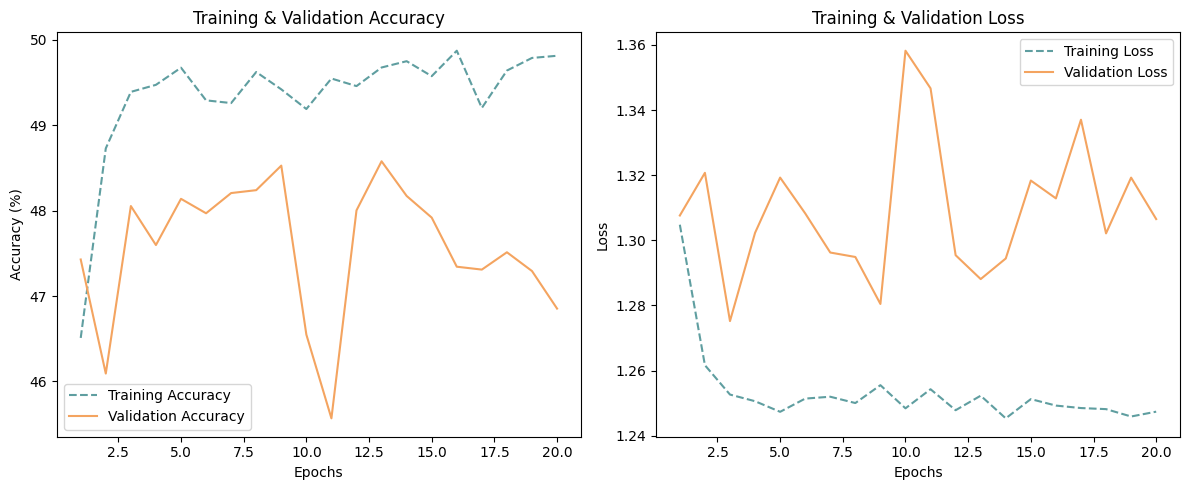

In [14]:
class TransformerDecoderBlock(nn.Module):  
    def __init__(self, hidden_dim, num_heads):         
        super().__init__()         
        self.self_attention = MultiHeadAttention(hidden_dim, num_heads)         
        self.norm1 = nn.LayerNorm(hidden_dim)         
        self.cross_attention = MultiHeadAttention(hidden_dim, num_heads)         
        self.norm2 = nn.LayerNorm(hidden_dim)         
        self.feed_forward = FeedForward(hidden_dim)         
        self.norm3 = nn.LayerNorm(hidden_dim)     
    @staticmethod     
    def add_causal_mask(mask):         # assuming attn scores of shape (batch_size, num_heads, seq_len, seq_len)         # assuming mask of shape (batch_size, 1, 1, seq_len)         causal_mask = torch.triu(torch.ones(1, 1, mask.size(-1), mask.size(-1)), diagonal=1).type(torch.int)  # shape (1, 1, seq_len, seq_len)         causal_mask = causal_mask == 0         # Ensure the mask is on the same device as the input         causal_mask.to(device)         return mask & causal_mask     def forward(self, x, enc_hidden_state, src_mask, tgt_mask):         # Call the static method using the class name         tgt_mask = TransformerDecoderBlock.add_causal_mask(tgt_mask)         attn_output = self.self_attention(x, x, x, tgt_mask)         x = x + attn_output         x = self.norm1(x)         attn_output = self.cross_attention(x, enc_hidden_state, enc_hidden_state, src_mask)         x = x + attn_output         x = self.norm2(x)         ff_output = self.feed_forward(x)         x = x + ff_output         x = self.norm3(x)         return x

# Dictionnaire pour stocker l’historique
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.head.parameters(), lr=1e-3)

device = "cuda" if torch.cuda.is_available() else "cpu"
model2.to(device)
 
    


for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    correct = 0
    total = 0
    t_epoch = time.time()

    for images, labels in tqdm(train_loader_aug_e, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calcul de l'accuracy train
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader_aug_e)
    train_acc = 100 * correct / total

    # Validation
    val_loss, val_acc = evaluate_loader(model2, val_loader_e, criterion)
    # Stocker l'historique
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    t_epoch = time.time() - t_epoch
    print(f"Epoch {epoch+1} took {t_epoch:.2f} sec")


plot_training_history(history)


**Overfitting donc faire du droptout**

In [15]:
print(train_acc)

49.814928403731045


In [57]:
img_path = "emotions/Data/Happy/27605.png"
Image.open(img_path).show()

### Evaluation du modèle

In [ ]:
model2.eval()
data_iter = iter(test_loader_e)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model2(images)
    _, preds = torch.max(outputs, 1)

class_names = full_dataset_emotions.classes  # liste des classes ImageFolder

# Choisir 4 indices aléatoires dans ce batch
rand_indices = random.sample(range(batch_size), 4)

plt.figure(figsize=(12,6))
for i, idx in enumerate(rand_indices):
    plt.subplot(2,4,i+1)
    img = images[idx].cpu()
    # undo normalisation
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    img = img.clamp(0,1)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

test_loss, test_acc = evaluate_loader(model2, test_loader_e, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")



### 